In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b


import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

In [2]:
def VGG16_AvgPool(shape):
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            x = AveragePooling2D()(x)
        else:
            x = layer(x)
    return Model(i, x)

In [3]:
def VGG16_AvgPool_CutOff(shape, num_convs):
    if num_convs < 1 or num_convs > 15:
        print("num_convs must be in the range [1, 13]")
        return None
    vgg = VGG16_AvgPool(shape)

    n = 0
    output = None
    for layer in vgg.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= num_convs:
            output = layer.output
            break

    return Model(vgg.input, output)

In [4]:
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    img = img[..., ::-1]
    return img

In [5]:
def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [6]:
path = 'cat.jpg'

In [7]:
new_size = (350, 350)
img = image.load_img(path, target_size=new_size)

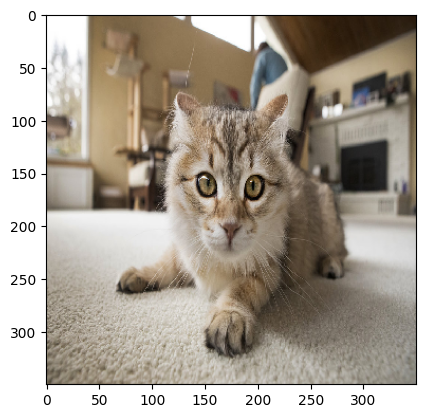

In [8]:
plt.imshow(img)

In [9]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [10]:
x.shape

(1, 350, 350, 3)

In [11]:
batch_shape = x.shape
shape = x.shape[1:]

shape

(350, 350, 3)

In [12]:
content_model = VGG16_AvgPool_CutOff(shape, 11)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_1:0


In [13]:
target = K.variable(content_model.predict(x))

C:\Users\Andrei\anaconda3\envs\tfenv\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [14]:
loss = K.mean(K.square(content_model.output - target))

In [15]:
grads = K.gradients(loss, content_model.input)

In [16]:
get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
)

In [17]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [18]:
losses = []
x = np.random.randn(np.prod(batch_shape))
for i in range(50):
    x, l, _ = fmin_l_bfgs_b(
        func=get_loss_and_grads_wrapper,
        x0=x,
        maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

iter=0, loss=1054.1458740234375
iter=1, loss=484.0337219238281
iter=2, loss=306.7700500488281
iter=3, loss=230.4068145751953
iter=4, loss=186.57162475585938
iter=5, loss=155.53915405273438
iter=6, loss=135.50926208496094
iter=7, loss=121.1390609741211
iter=8, loss=110.08159637451172
iter=9, loss=101.57125854492188
iter=10, loss=95.03653717041016
iter=11, loss=89.14603424072266
iter=12, loss=84.25203704833984
iter=13, loss=80.15189361572266
iter=14, loss=76.7885513305664
iter=15, loss=74.06671905517578
iter=16, loss=71.32771301269531
iter=17, loss=69.00172424316406
iter=18, loss=66.85409545898438
iter=19, loss=65.01768493652344
iter=20, loss=63.06101989746094
iter=21, loss=61.213321685791016
iter=22, loss=59.687625885009766
iter=23, loss=58.125091552734375
iter=24, loss=56.74135971069336
iter=25, loss=55.45720672607422
iter=26, loss=54.29814147949219
iter=27, loss=53.21372604370117
iter=28, loss=52.23816680908203
iter=29, loss=51.2942008972168
iter=30, loss=50.40448760986328
iter=31, lo

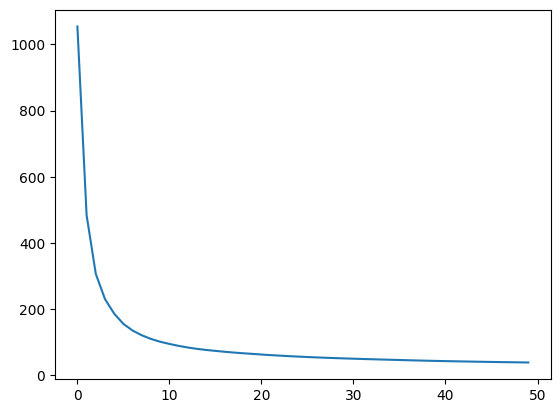

In [19]:
plt.plot(losses)

In [20]:
new_img = x.reshape(*batch_shape)
final_img = unpreprocess(new_img)

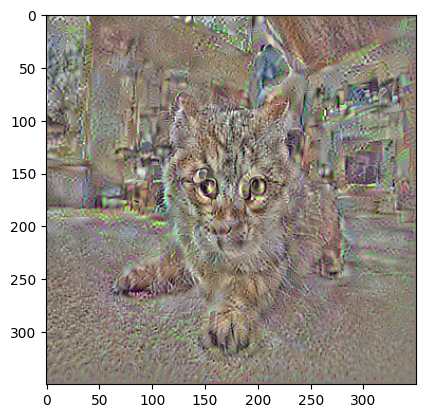

In [21]:
plt.imshow(scale_img(final_img[0]))

In [22]:
def gram_matrix(img):
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    G = K.dot(X, K.transpose(X))  # gram matrix G = XX^T
    return G

In [23]:
def style_loss(y, t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [24]:
def minimize(fn, epochs, batch_shape):
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
            func=fn,
            x0=x,
            maxfun=20
        )
        x = np.clip(x, -127, 127)
        losses.append(l)

    plt.plot(losses)
    plt.show()

    new_img = x.reshape(*batch_shape)
    final_img = unpreprocess(new_img)
    return final_img[0]

In [25]:
x = image.img_to_array(img)

In [26]:
x = np.expand_dims(x, axis=0)

In [27]:
x = preprocess_input(x)

In [28]:
batch_shape = x.shape
shape = x.shape[1:]

In [29]:
vgg = VGG16_AvgPool(shape)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0


In [30]:
vgg.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            multiple             0           input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 350, 350, 64) 1792        input_2[1][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 350, 350, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
average_pooling2d_5 (AveragePoo (None, 175, 175, 64) 0           block1_conv2[1][0]               
____________________________________________________________________________________________

In [31]:
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
]

In [32]:
symbolic_conv_outputs

[<tf.Tensor 'block1_conv1_3/Relu:0' shape=(None, 350, 350, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_3/Relu:0' shape=(None, 175, 175, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_3/Relu:0' shape=(None, 87, 87, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_3/Relu:0' shape=(None, 43, 43, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_3/Relu:0' shape=(None, 21, 21, 512) dtype=float32>]

In [33]:
style_model = Model(vgg.input, symbolic_conv_outputs)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0


In [34]:
style_layers_outputs = [K.variable(y) for y in style_model.predict(x)]

In [35]:
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    loss += style_loss(symbolic[0], actual[0])

In [36]:
grads = K.gradients(loss, vgg.input)

In [37]:
get_loss_and_grads = K.function(
    inputs=[style_model.input],
    outputs=[loss] + grads
)

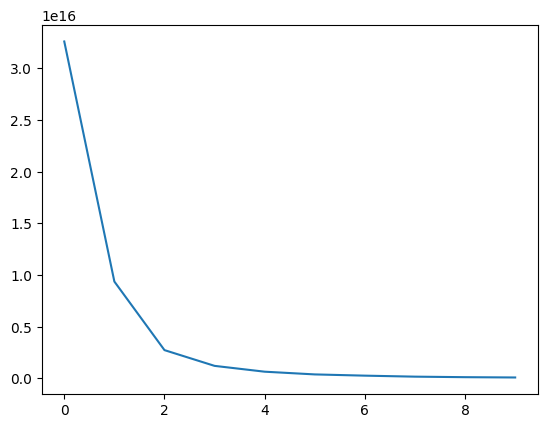

In [38]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)

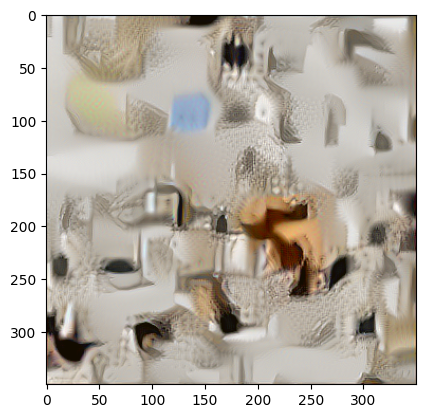

In [39]:
plt.imshow(scale_img(final_img))

In [40]:
def load_img_and_preprocess(path, shape=None):
    img = image.load_img(path, target_size=shape)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

In [58]:
content_img = load_img_and_preprocess('NY.jpg', (200, 200))

In [59]:
style_img = load_img_and_preprocess('style.png', (200, 200))

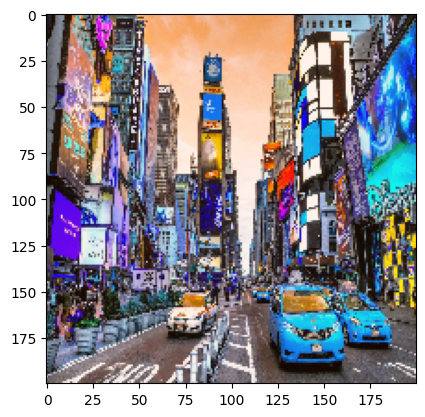

In [60]:
plt.imshow(scale_img(content_img[0]))

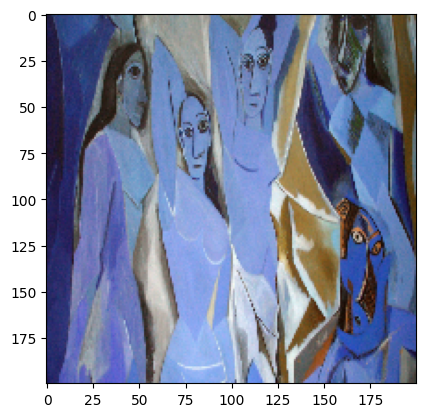

In [61]:
plt.imshow(scale_img(style_img[0]))

In [62]:
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [63]:
vgg = VGG16_AvgPool(shape)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_4:0


In [64]:
content_model = Model(vgg.input, vgg.layers[11].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_4:0


In [65]:
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers \
    if layer.name.endswith('conv1')
]

In [66]:
style_model = Model(vgg.input, symbolic_conv_outputs)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_4:0


In [67]:
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

In [68]:
style_weights = [0.2, 0.4, 0.3, 0.5, 0.2]

In [69]:
loss = K.mean(K.square(content_model.output - content_target))

In [70]:
for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
    loss += w * style_loss(symbolic[0], actual[0])

In [71]:
grads = K.gradients(loss, vgg.input)

In [72]:
get_loss_and_grads = K.function(
    inputs=[vgg.input],
    outputs=[loss] + grads
)

In [73]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

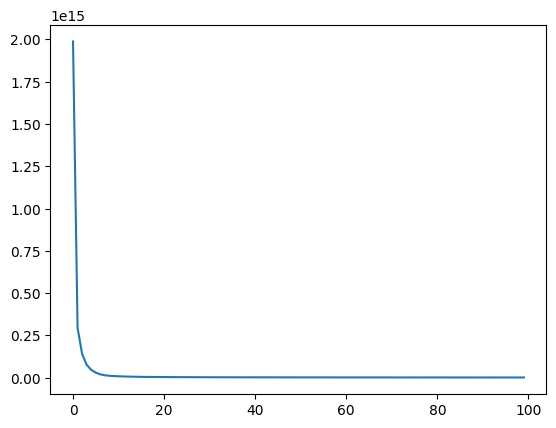

In [76]:
final_img = minimize(get_loss_and_grads_wrapper, 100, batch_shape)

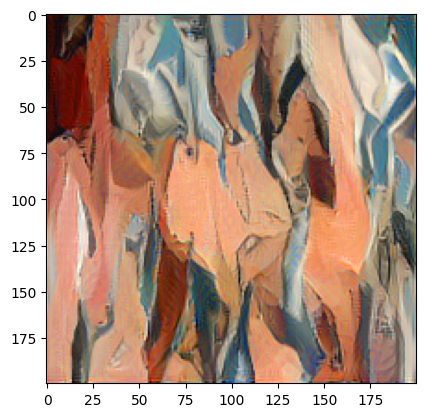

In [77]:
plt.imshow(scale_img(final_img))